In [ ]:
!apt-get install -y p7zip-full


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [ ]:
!7z x /content/archive.zip -o/content/pokemon_images/



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,96 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 11505572 bytes (11 MiB)

Extracting archive: /content/archive.zip
--
Path = /content/archive.zip
Type = zip
Physical Size = 11505572

  0%    Everything is Ok

Files: 453
Size:       16850503
Compressed: 11505572


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adampq/pokemon-tcg-all-cards-1999-2023")

print("Path to dataset files:", path)

100%|██████████| 1.78M/1.78M [00:00<00:00, 123MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/adampq/pokemon-tcg-all-cards-1999-2023/versions/1


In [ ]:
# Installation des dépendances nécessaires
!pip install fastai
!pip install fastbook

# Importation des bibliothèques
from fastai.vision.all import *
from fastai.vision.widgets import *
import os

# Configuration pour éviter les warnings
import warnings
warnings.filterwarnings('ignore')

# Fonction pour créer la structure de dossiers d'exemple
def create_sample_structure():
    # Création des dossiers de base
    base_path = '/content/pokemon_images/pokemon_images'
    os.makedirs(base_path, exist_ok=True)

In [ ]:
#trier le dataset N1
def trier():
  path = Path('/content/pokemon_images/test')
  open(fil)




Setting-up type transforms pipelines
Found 4554 items
2 datasets of sizes 3644,910
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/pokemon_images/pokemon_images/high_value/pokemon_high_1405_744de45f.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=224x224
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/pokemon_images/pokemon_images/high_value/pokemon_high_1405_744de45f.jpg
    applying parent_label gives
      high_value
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=224x224, TensorCategory(0))


Found 4554 items
2 datasets of sizes 3644,910
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': 

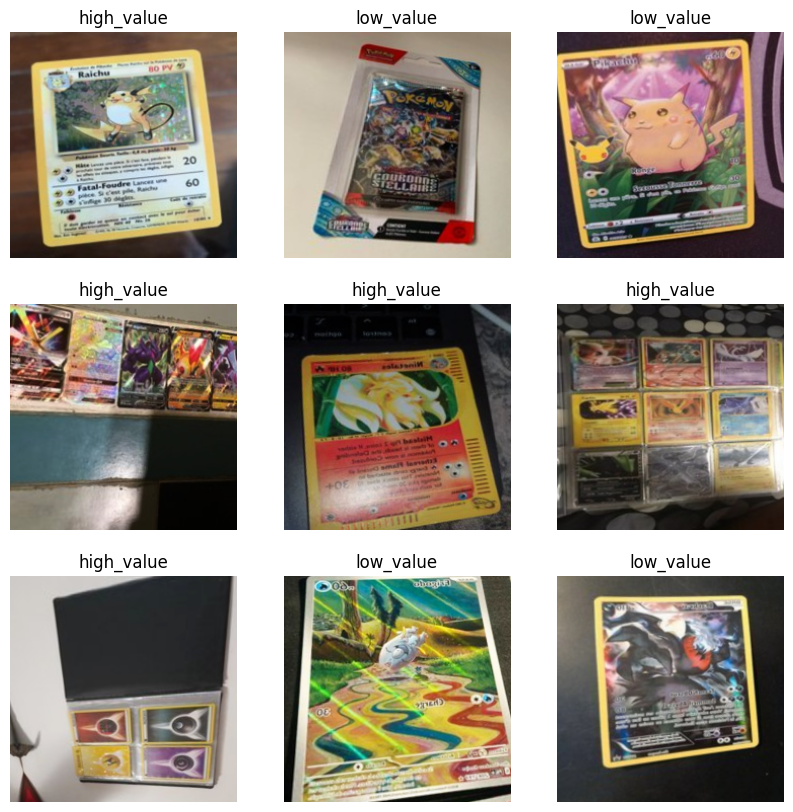

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 195MB/s]



Recherche du learning rate optimal...



Début de l'entraînement...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.646831,0.118196,0.039560,0.960440,01:03
1,0.264752,0.047469,0.023077,0.976923,01:02


Better model found at epoch 0 with accuracy value: 0.9604395627975464.


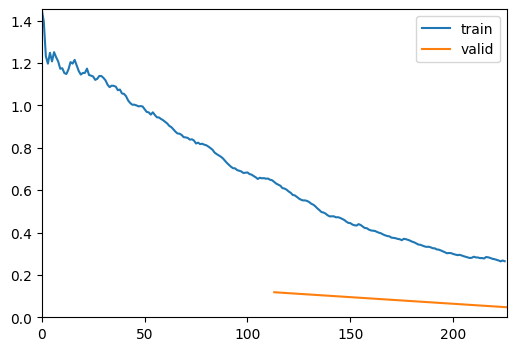

Better model found at epoch 1 with accuracy value: 0.9769230484962463.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.070124,0.001429,0.000000,1.000000,01:27
1,0.038060,0.000178,0.000000,1.000000,01:31
2,0.011523,0.000077,0.000000,1.000000,01:30
3,0.005160,0.000028,0.000000,1.000000,01:30


Better model found at epoch 0 with accuracy value: 1.0.


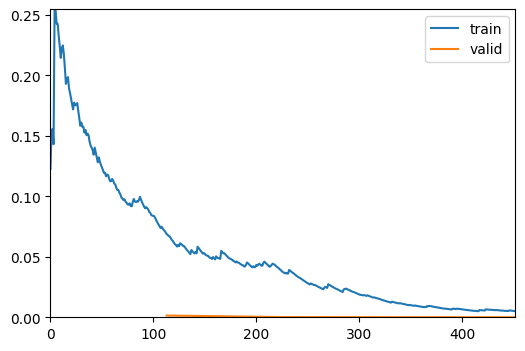

Erreur lors de la prédiction: [Errno 2] No such file or directory: '/content/pokemon_images/pokemon_images/high_value/example_card.jpg'


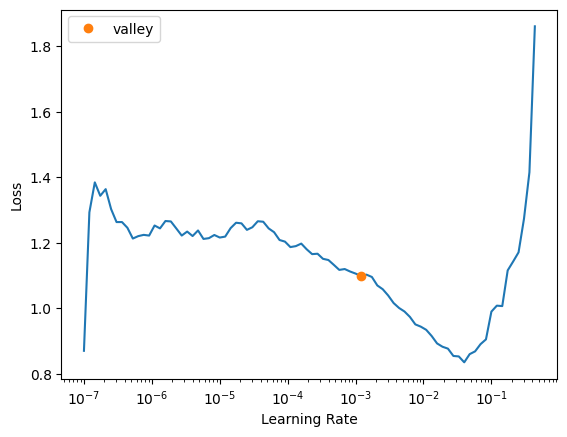

In [ ]:
from fastai.vision.all import *
from pathlib import Path
import matplotlib.pyplot as plt

def create_pokemon_classifier():
    # Définition du chemin vers les données
    path = Path('/content/pokemon_images/pokemon_images')

    # Vérification de l'existence des dossiers
    if not (path/'high_value').exists() or not (path/'low_value').exists():
        raise Exception("Les dossiers high_value et low_value doivent exister dans le chemin spécifié")

    # Création du DataBlock avec visualisation
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=[Resize(460)],
        batch_tfms=[*aug_transforms(size=224, min_scale=0.75)],
    )

    # Vérification de la structure des données
    try:
        dblock.summary(path)
    except Exception as e:
        print(f"Erreur lors de la vérification des données: {str(e)}")
        return None

    # Création des dataloaders
    try:
        dls = dblock.dataloaders(path, bs=32)

        # Affichage d'un batch d'images
        print("\nAffichage d'un exemple de batch:")
        dls.show_batch(max_n=9, figsize=(10,10))
        plt.show()

        # Création et entraînement du modèle
        learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])

        # Recherche du learning rate optimal
        print("\nRecherche du learning rate optimal...")
        learn.lr_find()

        # Entraînement du modèle
        print("\nDébut de l'entraînement...")
        learn.fine_tune(
            4,
            base_lr=1e-3,
            freeze_epochs=2,
            cbs=[
                SaveModelCallback(monitor='accuracy', comp=np.greater),
                ShowGraphCallback()
            ]
        )

        # Sauvegarde du modèle
        learn.export('pokemon_card_classifier.pkl')

        return learn

    except Exception as e:
        print(f"Une erreur s'est produite: {str(e)}")
        print("\nAssurez-vous d'avoir:")
        print("1. Créé les dossiers 'high_value' et 'low_value' dans le chemin spécifié")
        print("2. Ajouté des images de cartes Pokémon dans ces dossiers")
        return None

def predict_card(learn, image_path):
    """
    Prédit la valeur d'une carte Pokémon
    """
    try:
        img = PILImage.create(image_path)
        pred, pred_idx, probs = learn.predict(img)

        # Affichage de l'image et de la prédiction
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prédiction: {pred}\nProbabilité: {probs[pred_idx]:.4f}")
        plt.show()

        return pred, probs[pred_idx]

    except Exception as e:
        print(f"Erreur lors de la prédiction: {str(e)}")
        return None, None

# Exemple d'utilisation
if __name__ == "__main__":
    # Création et entraînement du modèle
    learn = create_pokemon_classifier()

    if learn is not None:
        # Exemple de prédiction
        image_path = "/content/pokemon_images/pokemon_images/high_value/example_card.jpg"
        predict_card(learn, image_path)

In [ ]:
from pathlib import Path
print(Path.cwd())

/content


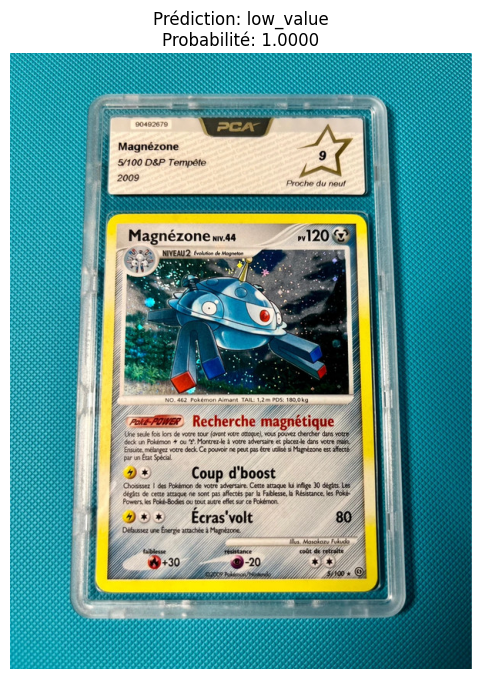

('low_value', tensor(1.0000))

In [ ]:
from fastai.vision.all import *
from pathlib import Path
import matplotlib.pyplot as plt

# Charger le modèle enregistré
learn = load_learner('pokemon_card_classifier.pkl')

def predict_card(image_path):
    """
    Prédit la valeur d'une carte Pokémon
    """
    try:
        img = PILImage.create(image_path)
        pred, pred_idx, probs = learn.predict(img)

        # Affichage de l'image et de la prédiction
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prédiction: {pred}\nProbabilité: {probs[pred_idx]:.4f}")
        plt.show()

        return pred, probs[pred_idx]

    except Exception as e:
        print(f"Erreur lors de la prédiction: {str(e)}")
        return None, None

# Exemple d'utilisation
image_path = "/content/1729105644.jpeg"
predict_card(image_path)